In [1]:
import tensorflow as tf
print(tf.test.is_gpu_available())
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
import numpy as np
import shutil
import re
path = os.getcwd()

trial = 1
dest_fpath = path + f"/DeepONet_v0{trial}/"
os.makedirs(os.path.dirname(dest_fpath), exist_ok=True, mode=0o777)
ckpt_fpath = path + f"/DeepONet_v0{trial}/Checkpoint/"
os.makedirs(os.path.dirname(ckpt_fpath), exist_ok=True, mode=0o777)
fig_fpath = path + f"/DeepONet_v0{trial}/fig/"
os.makedirs(os.path.dirname(fig_fpath), exist_ok=True, mode=0o777)

os.chmod(path + f"/DeepONet_v0{trial}", 0o777)
for root, dirs, files in os.walk(dest_fpath):
    for d in dirs:
        os.chmod(os.path.join(root, d), 0o777)
    for f in files:
        os.chmod(os.path.join(root, f), 0o777)

In [3]:
%matplotlib notebook

from zipfile import ZipFile
import os
import numpy as np
import shutil
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time


def get_all_file_paths(directory):
    file_paths = []
    file_directories = []
    for root, directories, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)
        file_directories.append(directories)
    return file_paths, file_directories

def get_DeepONet_data(train_data, train_label, Power, HTC, Die_xy, Die_z, t_Diel, t_Insulator, K_Diel):
    start_time = time.time()

#     y_train, s_train = train_data[:, :1], train_data[:, 1:2].reshape(-1, 1)
    y_train = train_data[:, -1:]
    s_train = np.clip(train_label, a_min=0, a_max =None)
    

    ## Try without local minmax scaling
    ## Try without local minmax scaling
#     s_train = s_train - s_train.min()
#     max_temp_local = s_train.max()
#     min_temp_local = s_train.min()
       
########################################## No need for scaling ##############################33
    # power_mag_n = np.log(Power*10**2) * 0.1
    # HTC_n = np.log(HTC*10**9) * 0.1
    # Die_xy_n = (Die_xy - 4000.0) / (30000.0 - 4000.0)
    # Die_z_n = (Die_z - 10.0) / (200.0 - 10.0)
    
    # At data generation:
    # t_Diel = np.random.uniform(low=1.0, high=10.1, size=(num_cases, 1))
    # t_Insulator = np.random.uniform(low=1.0, high=5.1, size=(num_cases, 1)) * 10**-2
    # t_Diel_n = (t_Diel - 1.0) / (10.1 - 1.0)
    # t_Insulator_n = (t_Insulator - 0.01) / (0.051 - 0.01)

    # K_Diel_n = np.log(K_Diel*10**3) * 0.1
########################################## No need for scaling ##############################33


#     y_train[:, 0] = y_train[:, 0] / (Die_xy / 2.0)
    # y_train = np.log(y_train*10**4)/21.0

    ## Global scaling of s_train
    # s_train = s_train/80.0
    
    #     u_train = np.asarray([power_mag_n, HTC_n, Die_xy_n, Die_z_n, t_Diel_n, t_Insulator_n, K_Diel_n])
    # u_train = np.asarray([HTC_n, t_Diel_n, t_Insulator_n, K_Diel_n])
    u_train = np.asarray([HTC, t_Diel, t_Insulator, K_Diel])
    u_train = np.tile(u_train, reps=(y_train.shape[0], 1))
    
#     xy_coordinates = u_train[:, -2:]
#     u_train = np.concatenate((u_train, xy_coordinates), axis=1)
#     print('xy_coordinates shape is: ', xy_coordinates.shape)
#     print('u_train shape is: ', u_train.shape)
#     print('train_data shape is: ', train_data.shape)
#     print('train_data[0] is: ', train_data[0])
#     raise
    
    # print("y_train max is: ", y_train.max())
    # print("y_train min is: ", y_train.min())
    # print("s_train max is: ", s_train.max())
    # print("s_train min is: ", s_train.min())
    # print("u_train max is: ", u_train.max())
    # print("u_train min is: ", u_train.min())
    
#     end_time = time.time()
#     total_time = end_time - start_time
    #     print("Total time consumed is: ", total_time)
#     power_test_BC = u_train[0, :].reshape(-1, 1)

    #     print("power_test_BC shape is: ", power_test_BC.shape)
    #     print("power_test_BC max is: ", power_test_BC.max())
    #     print("power_test_BC min is: ", power_test_BC.min())
    return u_train, y_train, s_train


def main():
    # path to folder which needs to be zipped
    directory = './Data_1000/One_tile_3D_data'
    save_data_path = dest_fpath + 'One_tile_3D_data_npz/'
    os.makedirs(os.path.dirname(save_data_path), exist_ok=True, mode=0o777)

    file_paths, file_dir = get_all_file_paths(directory)
    file_directories = file_dir[0]
    counter = 1

    data = 0

    workbench_u = np.empty((0, 4))
    # workbench_y = np.empty((0, 3))
    workbench_y = np.empty((0, 1))
#     workbench_s = np.empty((0, 1))
    workbench_s = np.empty((0, 9, 9))
    
    for folder in file_directories:
        source_dir = directory + '/' + folder + '/'
        # os.chdir(temp_working_dir)
        txt_name = "commands_trans_xy_decay_3200um.txt"
        source_file_name = source_dir + txt_name
        f = open(source_file_name, 'r')
        lines = f.readlines()

        Die_xy = int(re.findall("\d+", lines[22].split()[0])[0])
        Die_z = int(re.findall("\d+", lines[24].split()[0])[0])
        match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
        t_Insulator = float(re.findall(match_number, lines[25].split()[0])[0])
        t_Diel = float(re.findall(match_number, lines[26].split()[0])[0])
        tile_size = int(re.findall(match_number, lines[27].split()[0])[0])
        K_Diel = float(re.findall(match_number, lines[108].split()[1])[0])
        top_HTC = float(re.findall(match_number, lines[121].split()[0])[0])
        bottom_HTC = float(re.findall(match_number, lines[123].split()[0])[0])
        Power = float(re.findall(match_number, lines[131].split()[0])[0])
        HTC = top_HTC
#         print(f"Q_{Power}_HTC_{HTC}_xy_{Die_xy}_z_{Die_z}_tDiel_{t_Diel}_tIns_{t_Insulator}_Kd_{K_Diel}_Tile_{tile_size}\\")
        target_folder_name = save_data_path + f"Q_{Power}_HTC_{HTC}_xy_{Die_xy}_z_{Die_z}_tDiel_{t_Diel}_tIns_{t_Insulator}_Kd_{K_Diel}_Tile_{tile_size}\\"


        input_data_file_name = "raw_input.npy"
        output_data_file_name = "raw_output.npy"
        input_data = np.load(source_dir + input_data_file_name)
        output_data = np.load(source_dir + output_data_file_name)
        u, y, s = get_DeepONet_data(input_data, output_data, Power, HTC, Die_xy, Die_z, t_Diel, t_Insulator, K_Diel)
        print('s max is: ', s.max(), 'folder name is: ', target_folder_name)
#         num_pts_per_case = unit_size
#         idx = np.random.choice(u.shape[0], num_pts_per_case)
#         u = u[idx]
#         y = y[idx]
#         s = s[idx]
#         print('u shape is: ', u.shape)
#         print('y shape is: ', y.shape)
#         print('s shape is: ', s.shape)
#         raise
        workbench_u = np.vstack((workbench_u, u))
        workbench_y = np.vstack((workbench_y, y))
        workbench_s = np.vstack((workbench_s, s))
    print(f'workbench_u shape is {workbench_u.shape}')
    print(f'workbench_y shape is {workbench_y.shape}')
    print(f'workbench_s shape is {workbench_s.shape}')
    np.savez_compressed(save_data_path + "workbench_u", workbench_u)
    np.savez_compressed(save_data_path + "workbench_y", workbench_y)
    np.savez_compressed(save_data_path + "workbench_s", workbench_s)


if __name__ == "__main__":
    save_data_path = dest_fpath + 'One_tile_3D_data_npz/'
    start_time = time.time()
    main()
    print('The time took to generate data is: ', time.time() - start_time)
    workbench_u_f = np.load(save_data_path + "workbench_u.npz")
    workbench_y_f = np.load(save_data_path + "workbench_y.npz")
    workbench_s_f = np.load(save_data_path + "workbench_s.npz")
    workbench_u = workbench_u_f['arr_0']
    workbench_y = workbench_y_f['arr_0']
    workbench_s = workbench_s_f['arr_0']

    print(f"workbench_y[:, 0] min is {workbench_y[:, 0].min()}")
    print(f"workbench_y[:, 0] max is {workbench_y[:, 0].max()}")
    print(f"workbench_u[:, 0] min is {workbench_u[:, 0].min()}")
    print(f"workbench_u[:, 0] max is {workbench_u[:, 0].max()}")
    print(f"workbench_u[:, 1] min is {workbench_u[:, 1].min()}")
    print(f"workbench_u[:, 1] max is {workbench_u[:, 1].max()}")
    print(f"workbench_u[:, 2] min is {workbench_u[:, 2].min()}")
    print(f"workbench_u[:, 2] max is {workbench_u[:, 2].max()}")
    print(f"workbench_u[:, 3] min is {workbench_u[:, 3].min()}")
    print(f"workbench_u[:, 3] max is {workbench_u[:, 3].max()}")
    # print(f"workbench_u[:, 4] min is {workbench_u[:, 4].min()}")
    # print(f"workbench_u[:, 4] max is {workbench_u[:, 4].max()}")
    # print(f"workbench_u[:, 5] min is {workbench_u[:, 5].min()}")
    # print(f"workbench_u[:, 5] max is {workbench_u[:, 5].max()}")
    # print(f"workbench_u[:, 6] min is {workbench_u[:, 6].min()}")
    # print(f"workbench_u[:, 6] max is {workbench_u[:, 6].max()}")
    print(f"workbench_s min is {workbench_s.min()}")
    print(f"workbench_s max is {workbench_s.max()}")

s max is:  26.323999404907227 folder name is:  /home/ansysai/HaiyangHe/ThermalArtist/DecaySurface/3200um_9x9/DeepONet_v01/One_tile_3D_data_npz/Q_5000.0_HTC_2e-05_xy_16000_z_100_tDiel_2.2_tIns_0.028_Kd_0.02684_Tile_9\
s max is:  39.180999755859375 folder name is:  /home/ansysai/HaiyangHe/ThermalArtist/DecaySurface/3200um_9x9/DeepONet_v01/One_tile_3D_data_npz/Q_5000.0_HTC_1e-05_xy_16000_z_100_tDiel_7.7_tIns_0.023_Kd_0.11678_Tile_9\
s max is:  68.50700378417969 folder name is:  /home/ansysai/HaiyangHe/ThermalArtist/DecaySurface/3200um_9x9/DeepONet_v01/One_tile_3D_data_npz/Q_5000.0_HTC_3e-06_xy_16000_z_100_tDiel_4.5_tIns_0.018_Kd_0.04162_Tile_9\
s max is:  26.826000213623047 folder name is:  /home/ansysai/HaiyangHe/ThermalArtist/DecaySurface/3200um_9x9/DeepONet_v01/One_tile_3D_data_npz/Q_5000.0_HTC_2e-05_xy_16000_z_100_tDiel_8.8_tIns_0.017_Kd_0.02939_Tile_9\
s max is:  62.11000061035156 folder name is:  /home/ansysai/HaiyangHe/ThermalArtist/DecaySurface/3200um_9x9/DeepONet_v01/One_tile_3D_

In [4]:
workbench_s.max()

398.489990234375

In [5]:
# u_train = np.asarray([HTC_n, t_Diel_n, t_Insulator_n, K_Diel_n])
# HTC: [1e-9-- 2e-5]
# t_Diel: 1-10
# t_Insulator: [0.01-0.05]
# K_Diel: [0.00138--0.138]

# HTC_n = np.log(HTC*10**9) * 0.1
# t_Diel_n = (t_Diel - 1.0) / (10.0 - 1.0)
# t_Insulator_n = (t_Insulator - 0.01) / (0.05 - 0.01)
# K_Diel_n = np.log(K_Diel*10**3) * 0.1

# HTC_n 
print(np.log(1e-9*10**9) * 0.1, np.log(2e-5*10**9) * 0.1)
# t_Diel_n (1--10)
print((1 - 1.0) / (10.0 - 1.0), (10 - 1.0) / (10.0 - 1.0))
# t_Insulator_n (0.01--0.05)
print((0.01 - 0.01) / (0.05 - 0.01), (0.05 - 0.01) / (0.05 - 0.01))
# K diel
print(np.log(0.00138*10**3) * 0.1, np.log(0.138*10**3) * 0.1)

0.0 0.9903487552536128
0.0 1.0
0.0 1.0
0.03220834991691132 0.4927253685157205


## Train test split

In [6]:
%matplotlib inline
save_data_path = dest_fpath + 'One_tile_3D_data_npz/'
workbench_u_f = np.load(save_data_path + "workbench_u.npz")
workbench_y_f = np.load(save_data_path + "workbench_y.npz")
workbench_s_f = np.load(save_data_path + "workbench_s.npz")
workbench_u = workbench_u_f['arr_0']
workbench_y = workbench_y_f['arr_0']
workbench_s = workbench_s_f['arr_0']

unit_size = 70
total_num_data = int(workbench_u.shape[0] / unit_size)
print("total_num_data is: ", total_num_data)

train_idx = np.random.choice(total_num_data, size = 900, replace = False)
test_idx = np.setxor1d(np.arange(total_num_data), train_idx)

# train_idx = np.random.choice(total_num_data, size = total_num_data, replace = False)
# test_idx = train_idx

# train_idx = np.append(np.arange(25, 50), np.arange(175, 225))
# test_idx = train_idx

u_train = np.empty((0, workbench_u.shape[1]))
y_train = np.empty((0, workbench_y.shape[1]))
s_train = np.empty((0, workbench_s.shape[1], workbench_s.shape[1]))
# sdf_train = np.empty((0, workbench_y.shape[1]))
for idx in train_idx:
    t_u = np.take(workbench_u, np.array(np.arange(idx*unit_size, (idx + 1)*unit_size)), axis = 0)
    t_y = np.take(workbench_y, np.array(np.arange(idx*unit_size, (idx + 1)*unit_size)), axis = 0)
    t_s = np.take(workbench_s, np.array(np.arange(idx*unit_size, (idx + 1)*unit_size)), axis = 0)
    
#     sdf = 1 - t_y
#     sdf = 1 / (1 + np.exp(10*t_y-4))
    
    u_train = np.vstack((u_train, t_u))
    y_train = np.vstack((y_train, t_y))
    s_train = np.vstack((s_train, t_s))
#     sdf_train = np.vstack((sdf_train, sdf))
print("The shape of u_train is: ", u_train.shape)
print("The shape of y_train is: ", y_train.shape)
print("The shape of s_train is: ", s_train.shape)
# print("The shape of sdf_train is: ", sdf_train.shape)

u_test = np.empty((0, workbench_u.shape[1]))
y_test = np.empty((0, workbench_y.shape[1]))
s_test = np.empty((0, workbench_s.shape[1], workbench_s.shape[1]))

for idx in test_idx:
    t_u = np.take(workbench_u, np.array(np.arange(idx*unit_size, (idx + 1)*unit_size)), axis = 0)
    t_y = np.take(workbench_y, np.array(np.arange(idx*unit_size, (idx + 1)*unit_size)), axis = 0)
    t_s = np.take(workbench_s, np.array(np.arange(idx*unit_size, (idx + 1)*unit_size)), axis = 0)
    
    
    u_test = np.vstack((u_test, t_u))
    y_test = np.vstack((y_test, t_y))
    s_test = np.vstack((s_test, t_s))
print("The shape of u_test is: ", u_test.shape)
print("The shape of y_test is: ", y_test.shape)
print("The shape of s_test is: ", s_test.shape)

power_test_BC = u_train[0, :].reshape(-1, 1)
# print("The shape of temp_scaling_factor_train is: ", temp_scaling_factor_train.shape)
# print("The shape of temp_scaling_factor_test is: ", temp_scaling_factor_test.shape)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(y_train[:unit_size, :], sdf_train[:unit_size, :])

total_num_data is:  1000
The shape of u_train is:  (63000, 4)
The shape of y_train is:  (63000, 1)
The shape of s_train is:  (63000, 9, 9)
The shape of u_test is:  (7000, 4)
The shape of y_test is:  (7000, 1)
The shape of s_test is:  (7000, 9, 9)


In [7]:
workbench_u = workbench_u_f['arr_0']
workbench_y = workbench_y_f['arr_0']
workbench_s = workbench_s_f['arr_0']
print('workbench_u max is: ', workbench_u.max())
print('workbench_y max is: ', workbench_y.max())
print('workbench_s max is: ', workbench_s.max())

workbench_u max is:  10.1
workbench_y max is:  100000.0
workbench_s max is:  398.489990234375


## Scale s_train and s_test


In [8]:
## Temperature scaling for 210 um is 80.5
## Temperature scaling for 3200 um is 400
# s_train = s_train/80.5
# s_test = s_test/80.5
s_train = s_train/400.0
s_test = s_test/400.0
print(f's_train max is: {s_train.max()}, s_train max is: {s_train.min()}')
print(f's_test max is: {s_test.max()}, s_test max is: {s_test.min()}')

s_train max is: 0.9962249755859375, s_train max is: 0.0
s_test max is: 0.32290000915527345, s_test max is: 0.0


In [9]:
# u_train = u_train[:unit_size, :]
# y_train = y_train[:unit_size, :]
# s_train = s_train[:unit_size, :]
# sdf_train = sdf_train[:unit_size, :]
# u_test = u_test[:unit_size, :]
# y_test = y_test[:unit_size, :]
# s_test = s_test[:unit_size, :]
# print('u_train shape is: ', u_train.shape)
# print('y_train shape is: ', y_train.shape)
# print('s_train shape is: ', s_train.shape)
# print('sdf_train shape is: ', sdf_train.shape)
# print('u_test shape is: ', u_test.shape)
# print('y_test shape is: ', y_test.shape)
# print('s_test shape is: ', s_test.shape)

## The following is just a template for custom layer

In [10]:
from tensorflow import keras
from tensorflow.python.ops import math_ops
class Rescaling(tf.keras.layers.Layer):
#   """Multiply inputs by `scale` and adds `offset`.
#   For instance:
#   1. To rescale an input in the `[0, 255]` range
#   to be in the `[0, 1]` range, you would pass `scale=1./255`.
#   2. To rescale an input in the `[0, 255]` range to be in the `[-1, 1]` range,
#   you would pass `scale=1./127.5, offset=-1`.
#   The rescaling is applied both during training and inference.
#   Input shape:
#     Arbitrary.
#   Output shape:
#     Same as input.
#   Arguments:
#     scale: Float, the scale to apply to the inputs.
#     offset: Float, the offset to apply to the inputs.
#     name: A string, the name of the layer.
#   """
    def __init__(self, scale, offset=0., name=None, **kwargs):
        self.scale = scale
        self.offset = offset
        super(Rescaling, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        dtype = self._compute_dtype
        scale = math_ops.cast(self.scale, dtype)
        offset = math_ops.cast(self.offset, dtype)
        return math_ops.cast(inputs, dtype) * scale + offset

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'scale': self.scale,
            'offset': self.offset,
        }
        base_config = super(Rescaling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
# inputA = Input(shape=(7,))
# inputB = Input(shape=(1,))
# out = Rescaling(1)(inputA)

## Custom layer for u

In [11]:
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Input

class Rescaling_u(tf.keras.layers.Layer):
#     s_train = s_train - s_train.min()
#     max_temp_local = s_train.max()
#     min_temp_local = s_train.min()
## Scale s_train and s_test
#     s_train = (s_train - min_temp_local) / (max_temp_local - min_temp_local)

    def __init__(self, name=None, **kwargs):
        self.scale = 1
        self.offset = 0.0
        super(Rescaling_u, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        dtype = self._compute_dtype
#         # Power = inputs[:, 0:1]
#         HTC = inputs[:, 1:2]
#         # Die_xy = inputs[:, 2:3]
#         # Die_z = inputs[:, 3:4]
#         t_Diel = inputs[:, 4:5]
#         t_Insulator = inputs[:, 5:6]
#         K_Diel = inputs[:, 6:7]
        
        HTC = inputs[:, 0:1]
        t_Diel = inputs[:, 1:2]
        t_Insulator = inputs[:, 2:3]
        K_Diel = inputs[:, 3:4]
#         x_coord = inputs[:, 4:5]
#         y_coord = inputs[:, 5:6]
    
        # power_mag_n = tf.math.log(Power*10**2) * 0.1
        HTC_n = tf.math.log(HTC*10**9) * 0.1
        # Die_xy_n = (Die_xy - 4000.0) / (30000.0 - 4000.0)
        # Die_z_n = (Die_z - 10.0) / (200.0 - 10.0)
        # At data generation:
        # t_Diel = np.random.uniform(low=1.0, high=10.1, size=(num_cases, 1))
        # t_Insulator = np.random.uniform(low=1.0, high=5.1, size=(num_cases, 1)) * 10**-2
        t_Diel_n = (t_Diel - 1.0) / (10.1 - 1.0)
        t_Insulator_n = (t_Insulator - 0.01) / (0.051 - 0.01)
        K_Diel_n = tf.math.log(K_Diel*10**3) * 0.1
    
#     y_train[:, 0] = y_train[:, 0] / (Die_xy / 2.0)
        # inputs = tf.concat([power_mag_n, HTC_n, Die_xy_n, Die_z_n, t_Diel_n, t_Insulator_n, K_Diel_n], 1)
#         inputs = tf.concat([HTC_n, t_Diel_n, t_Insulator_n, K_Diel_n, x_coord, y_coord], 1)
        inputs = tf.concat([HTC_n, t_Diel_n, t_Insulator_n, K_Diel_n], 1)
#         scale = math_ops.cast(self.scale, dtype)
#         offset = math_ops.cast(self.offset, dtype)
        return math_ops.cast(inputs, dtype)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'scale': self.scale,
            'offset': self.offset,
        }
        base_config = super(Rescaling_u, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
inputA = Input(shape=(4,))
# inputB = Input(shape=(1,))
out = Rescaling_u()(inputA)
print('out shape is: ', out.shape)

out shape is:  (None, 4)


## Custom layer for y

In [12]:
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Input

# class Rescaling_y(tf.keras.layers.Layer):
#     def __init__(self, Die_xy, name=None, **kwargs):
#         self.Die_xy = Die_xy
#         super(Rescaling_y, self).__init__(name=name, **kwargs)

#     def call(self, inputs):
#         dtype = self._compute_dtype
#         inputs = inputs[:, 0:1] / (self.Die_xy / 2.0)
# #         scale = math_ops.cast(self.scale, dtype)
# #         offset = math_ops.cast(self.offset, dtype)
#         return math_ops.cast(inputs, dtype)

#     def compute_output_shape(self, input_shape):
#         return input_shape

#     def get_config(self):
#         config = {
#             'Die_xy': self.Die_xy,
#         }
#         base_config = super(Rescaling_y, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))


# inputB = Input(shape=(1,))
# Die_xy = u_train[0, 2:3]
# inputB_scale = Rescaling_y(Die_xy)(inputB)

# out = Rescaling_y(Die_xy)(inputB)
############# For TTSS y is t and y scaling will be # y_train = np.log(y_train*10**4)/21.0
class Rescaling_y(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        self.scale = 1
        self.offset = 0.0
        super(Rescaling_y, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        dtype = self._compute_dtype
        # inputs = inputs[:, 0:1] / (self.Die_xy / 2.0)
        inputs = tf.math.log(inputs[:, 0:1]*10**4)/21.0
#         scale = math_ops.cast(self.scale, dtype)
#         offset = math_ops.cast(self.offset, dtype)
        return math_ops.cast(inputs, dtype)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'scale': self.scale,
            'offset': self.offset,
        }
        base_config = super(Rescaling_y, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

inputB = Input(shape=(1,))
inputB_scale = Rescaling_y()(inputB)

out = Rescaling_y()(inputB)
print('out shape is: ', out.shape)

out shape is:  (None, 1)


In [13]:
s_train.max(), s_train.min(),s_train.shape

(0.9962249755859375, 0.0, (63000, 9, 9))

In [14]:
# s_train_max = np.max(s_train.reshape(-1, unit_size), axis=1)
# s_train_max_v = np.empty((0, 1))
# for i, s_max in enumerate(s_train_max):
#     s_train_max_v = np.vstack((s_train_max_v, np.tile(s_max, (unit_size, 1))))
    
# s_train_min = np.min(s_train.reshape(-1, unit_size), axis=1)
# s_train_min_v = np.empty((0, 1))
# for i, s_min in enumerate(s_train_min):
#     s_train_min_v = np.vstack((s_train_min_v, np.tile(s_min, (unit_size, 1))))
    
# s_train = (s_train - s_train_min_v) / (s_train_max_v - s_train_min_v)

# s_test_max = np.max(s_test.reshape(-1, unit_size), axis=1)
# s_test_max_v = np.empty((0, 1))
# for i, s_max in enumerate(s_test_max):
#     s_test_max_v = np.vstack((s_test_max_v, np.tile(s_max, (unit_size, 1))))
    
# s_test_min = np.min(s_test.reshape(-1, unit_size), axis=1)
# s_test_min_v = np.empty((0, 1))
# for i, s_min in enumerate(s_test_min):
#     s_test_min_v = np.vstack((s_test_min_v, np.tile(s_min, (unit_size, 1))))
    
# s_test = (s_test - s_test_min_v) / (s_test_max_v - s_test_min_v)

In [15]:
s_train.shape

(63000, 9, 9)

In [16]:
u_train.shape, y_train.shape, u_train.max(),  u_train.min()

((63000, 4), (63000, 1), 10.1, 1e-08)

## Training the net (faster)

In [17]:
import tensorflow as tf
# tf.keras.backend.set_floatx('float64')
# import numpy as np
from tensorflow.keras import Model, losses
from tensorflow.keras.layers import Input, Dense, Reshape, Multiply, Lambda
import time
# import keras
from tensorflow.keras.optimizers import Adam
import types
# import tempfile
# import keras.models
tf.keras.backend.set_floatx('float32')

# activation = tf.keras.activations.swish
activation = tf.keras.activations.relu
    
# define two sets of inputs
# inputA = Input(shape=(6,))
inputA = Input(shape=(4,))
inputB = Input(shape=(1,))


inputA_scale = Rescaling_u()(inputA)
# Die_xy = u_train[0, 2:3]
# inputB_scale = Rescaling_y(Die_xy)(inputB)

inputB_scale = Rescaling_y()(inputB)

num_neuron = 32

# the first branch operates on the first input
x = Dense(num_neuron, activation=activation)(inputA_scale)
x = Dense(num_neuron, activation=activation)(x)
# x = Dense(num_neuron, activation=activation)(x)
# x = Dense(num_neuron, activation=activation)(x)
# x = Dense(num_neuron, activation=activation)(x)
x = Dense(num_neuron, activation=activation)(x)
x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Dense(num_neuron, activation=activation)(inputB_scale)
y = Dense(num_neuron, activation=activation)(y)
# y = Dense(num_neuron, activation=activation)(y)
# y = Dense(num_neuron, activation=activation)(y)
# y = Dense(num_neuron, activation=activation)(y)
y = Dense(num_neuron, activation=activation)(y)
y = Model(inputs=inputB, outputs=y)

combined = Multiply()([x.output, y.output])
# out = tf.math.reduce_sum(combined, axis = 1)
# out = tf.keras.backend.reshape(out, (-1, 1))
out = Dense(64, activation=activation)(combined)
out = Dense(9*9)(out)
out = tf.keras.backend.reshape(out, (-1, 9, 9))

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=out)

# model.summary()

trainEpochVector = []
trainLossVector = []
testLossVector = []
def plotLossHistory(trainEpochVector, trainLossVector, testLossVector):        
    font_size = 12
    fig_loss, ax_loss = plt.subplots()
    plt.rcParams.update({'font.size': font_size})
    plt.subplots_adjust(left=0.25, bottom=0.15, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    ax_loss.plot(trainEpochVector, np.log10(trainLossVector), 'b-.')
    ax_loss.plot(trainEpochVector, np.log10(testLossVector), 'r-*')
    ax_loss.legend(['Train loss', 'Test loss'])
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel("Log loss")
    ax_loss.title.set_text('Total loss history')
    fig_loss_history = fig_fpath + "LossHistory.png"
    plt.savefig(fig_loss_history)
    plt.close()

def test_and_save(model, epoch):        
    font_size = 40
    fig = plt.figure(figsize=(40, 12), dpi = 100, facecolor='white')
    plt.rcParams.update({'font.size': font_size})
    fig.suptitle('DeepONet on test set', y=0.99)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.85, wspace=0.25, hspace=0.1)
    num_subplot = 1
    idx = np.random.choice(u_test.shape[0] // unit_size)
    for i in range(num_subplot):            
        u_validate = u_test[idx * unit_size: (idx+1)*unit_size, :]
        y_validate = y_test[idx * unit_size: (idx+1)*unit_size, :]
        s_validate = s_test[idx * unit_size: (idx+1)*unit_size, :]

        time_sample = np.random.choice(70)
        u_validate = u_validate[time_sample: (time_sample+1), :]
        y_validate = y_validate[time_sample: (time_sample+1), :]
        s_validate = s_validate[time_sample: (time_sample+1), :, :]
        
        s_pred = model.predict([u_validate, y_validate])
        axs = fig.add_subplot(131)
#         im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_validate, cmap = 'jet', alpha = 0.9)
#         im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_validate, cmap = 'jet', alpha = 0.9)
        im = axs.imshow(s_validate[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("Ground Truth")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(132)
#         im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_pred, cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_pred, cmap = 'jet', alpha = 0.9)
        im = axs.imshow(s_pred[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Prediction")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(133)
#         im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        im = axs.imshow(np.abs(s_pred[0, :, :] - s_validate[0, :, :]), cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Error")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

    path = f"./DeepONet_v0{trial}/fig/"
    fig_test_name = path + "Test_tf_pred_epoch_{0}.png".format(epoch)
    plt.savefig(fig_test_name)
    plt.close()
        
def validate_and_save(model, epoch):        
    font_size = 40
    fig = plt.figure(figsize=(40, 12), dpi = 100, facecolor='white')
    plt.rcParams.update({'font.size': font_size})

    fig.suptitle('DeepONet on training set', y=0.99)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.85, wspace=0.25, hspace=0.1)

    num_subplot = 1
    idx = np.random.choice(u_train.shape[0] // unit_size)

    for i in range(num_subplot):   
        u_validate = u_train[idx * unit_size: (idx+1)*unit_size, :]
        y_validate = y_train[idx * unit_size: (idx+1)*unit_size, :]
        s_validate = s_train[idx * unit_size: (idx+1)*unit_size, :]
        
        time_sample = np.random.choice(70)
        u_validate = u_validate[time_sample: (time_sample+1), :]
        y_validate = y_validate[time_sample: (time_sample+1), :]
        s_validate = s_validate[time_sample: (time_sample+1), :, :]
        

#         tf_dict = {self.X_func_tf: u_validate, self.X_loc_tf: y_validate} 
#         s_pred = self.sess.run(self.y_pred, tf_dict)
        s_pred = model.predict([u_validate, y_validate])

        axs = fig.add_subplot(131)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_validate, cmap = 'jet', alpha = 0.9)
#         im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_validate, cmap = 'jet', alpha = 0.9)
        im = axs.imshow(s_validate[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("Ground Truth")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(132)
#         im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_pred, cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_pred, cmap = 'jet', alpha = 0.9)
        im = axs.imshow(s_pred[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Prediction")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(133)
#         im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        im = axs.imshow(np.abs(s_pred[0, :, :] - s_validate[0, :, :]), cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Error")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

    path = f"./DeepONet_v0{trial}/fig/"
    fig_test_name = path + "Validation_tf_pred_epoch_{0}.png".format(epoch)
    plt.savefig(fig_test_name)
    plt.close()

    
    
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2),
#     tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5',save_freq='epoch'),\
    tf.keras.callbacks.ModelCheckpoint(filepath = path + f"/DeepONet_v0{trial}/Checkpoint/model.h5", monitor='val_loss',\
                                       save_weights_only=False, save_best_only=True, save_freq='epoch'),
    tf.keras.callbacks.TensorBoard(log_dir = path + f"/DeepONet_v0{trial}/logs/")
    # lr_callback
]

optimizer = Adam(learning_rate=1e-4)
with tf.device('/device:GPU:1'):
    model.compile(optimizer=optimizer, loss="mse")
    EPOCH = 25000
    
    load_model_plot = True
    load_model_and_train = True
    if load_model_plot:
        model.built = True
        model.load_weights(path + f"/DeepONet_v0{trial}/Checkpoint/" + 'model.h5')
    elif load_model_and_train:
        model.built = True
        model.compile(optimizer=optimizer, loss='mse')
        model.load_weights(path + f"/DeepONet_v0{trial}/Checkpoint/" + 'model.h5')
#         history = model.fit([u_train, y_train], s_train, batch_size=u_train.shape[0],\
#                  validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)
        history = model.fit([u_train, y_train], s_train, batch_size=256,\
                 validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)

        # train_loss = history.history['loss']
        # val_loss = history.history['val_loss']

        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.semilogy(train_loss)
        # ax.semilogy(val_loss)
        # ax.legend(['train loss', 'val loss'])
        # plt.savefig(work_dir + 'loss')
        
        font_size = 12
        plt.rcParams.update({'font.size': font_size})
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.semilogy(train_loss)
        ax.semilogy(val_loss)
        ax.legend(['train', 'validation'])
        plt.savefig(path + f"/DeepONet_v0{trial}/" + 'loss_history')
    else:
        model.compile(optimizer=optimizer, loss='mse')
#         history = model.fit([u_train, y_train], s_train, batch_size=u_train.shape[0],\
#                  validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)
        history = model.fit([u_train, y_train], s_train, batch_size=256,\
                 validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.semilogy(train_loss)
        ax.semilogy(val_loss)
        ax.legend(['train loss', 'val loss'])
        plt.savefig(path + f"/DeepONet_v0{trial}/" + 'loss')
    
    # plotLossHistory(trainEpochVector, trainLossVector, testLossVector)
    test_and_save(model, EPOCH)
    validate_and_save(model, EPOCH)
    print('Done')

Done


In [1]:
test_and_save(model, EPOCH)
validate_and_save(model, EPOCH)

NameError: name 'test_and_save' is not defined

In [18]:
# load the model from disk
# load the model from disk
loaded_model = model.load_weights(path + f"/DeepONet_v0{trial}/Checkpoint/" + 'model.h5')

# X_train = params_train
# Y_train = temp_max_train 

# result = loaded_model.score(X_train, Y_train)
# print(result)

pred_all = model.predict([u_train, y_train])
ground_truth_all = s_train
relative_l2_test = np.linalg.norm(ground_truth_all.flatten() - \
            pred_all.flatten()) / np.linalg.norm(ground_truth_all.flatten())
print('relative_l2_test is: ', relative_l2_test)

pred_all = model.predict([u_test, y_test])
ground_truth_all = s_test
relative_l2_train = np.linalg.norm(ground_truth_all.flatten() -\
            pred_all.flatten()) / np.linalg.norm(ground_truth_all.flatten())
print('relative_l2_train is: ', relative_l2_train)

relative_l2_test is:  0.006627443515074852
relative_l2_train is:  0.009019062633910184


In [41]:
test_and_save(model, EPOCH)
validate_and_save(model, EPOCH)

In [22]:
u_train.shape, y_train.shape, s_train.shape

((180000, 6), (180000, 1), (180000, 1))

In [20]:
u_test[0, :]

array([9.00e-06, 4.50e+00, 3.70e-02, 8.33e-02, 3.70e-02, 8.33e-02])

In [19]:
u_test.max(), y_test.max(), s_test.max()

(10.0, 1.0, 0.5179503067680027)

In [ ]:
import tensorflow as tf
# tf.keras.backend.set_floatx('float64')
# import numpy as np
from tensorflow.keras import Model, losses
from tensorflow.keras.layers import Input, Dense, Reshape, Multiply, Lambda
import time
# import keras
from tensorflow.keras.optimizers import Adam
import types
# import tempfile
# import keras.models
tf.keras.backend.set_floatx('float32')

# activation = tf.keras.activations.swish
activation = tf.keras.activations.relu
    
# define two sets of inputs
inputA = Input(shape=(6,))
inputB = Input(shape=(1,))


inputA_scale = Rescaling_u()(inputA)
# Die_xy = u_train[0, 2:3]
# inputB_scale = Rescaling_y(Die_xy)(inputB)

inputB_scale = Rescaling_y()(inputB)

num_neuron = 32

# the first branch operates on the first input
x = Dense(num_neuron, activation=activation)(inputA_scale)
# x = Dense(num_neuron, activation=activation)(x)
# x = Dense(num_neuron, activation=activation)(x)
# x = Dense(num_neuron, activation=activation)(x)
# x = Dense(num_neuron, activation=activation)(x)
x = Dense(num_neuron, activation=activation)(x)
x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Dense(num_neuron, activation=activation)(inputB_scale)
# y = Dense(num_neuron, activation=activation)(y)
# y = Dense(num_neuron, activation=activation)(y)
# y = Dense(num_neuron, activation=activation)(y)
# y = Dense(num_neuron, activation=activation)(y)
y = Dense(num_neuron, activation=activation)(y)
y = Model(inputs=inputB, outputs=y)

combined = Multiply()([x.output, y.output])
out = tf.math.reduce_sum(combined, axis = 1)
out = tf.keras.backend.reshape(out, (-1, 1))
# out = Dense(128, activation=activation)(combined)
# out = Dense(21*21)(out)
# out = tf.keras.backend.reshape(out, (-1, 1))

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=out)

# model.summary()

trainEpochVector = []
trainLossVector = []
testLossVector = []
def plotLossHistory(trainEpochVector, trainLossVector, testLossVector):        
    font_size = 12
    fig_loss, ax_loss = plt.subplots()
    plt.rcParams.update({'font.size': font_size})
    plt.subplots_adjust(left=0.25, bottom=0.15, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    ax_loss.plot(trainEpochVector, np.log10(trainLossVector), 'b-.')
    ax_loss.plot(trainEpochVector, np.log10(testLossVector), 'r-*')
    ax_loss.legend(['Train loss', 'Test loss'])
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel("Log loss")
    ax_loss.title.set_text('Total loss history')
    fig_loss_history = fig_fpath + "LossHistory.png"
    plt.savefig(fig_loss_history)
    plt.close()

def test_and_save(model, epoch):        
    font_size = 40
    fig = plt.figure(figsize=(40, 12), dpi = 100)
    plt.rcParams.update({'font.size': font_size})
    fig.suptitle('DeepONet on test set', y=0.99)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.85, wspace=0.25, hspace=0.1)
    num_subplot = 1
    idx = np.random.choice(u_test.shape[0] // unit_size)
    for i in range(num_subplot):            
        u_validate = u_test[idx * unit_size: (idx+1)*unit_size, :]
        y_validate = y_test[idx * unit_size: (idx+1)*unit_size, :]
        s_validate = s_test[idx * unit_size: (idx+1)*unit_size, :, :]

#         time_sample = np.random.choice(70)
#         u_validate = u_validate[time_sample: (time_sample+1), :]
#         y_validate = y_validate[time_sample: (time_sample+1), :]
#         s_validate = s_validate[time_sample: (time_sample+1), :, :]
        
        s_pred = model.predict([u_validate, y_validate])
        axs = fig.add_subplot(131)
        im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_validate, cmap = 'jet', alpha = 0.9)
#         im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_validate, cmap = 'jet', alpha = 0.9)
#         im = axs.imshow(s_validate[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("Ground Truth")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(132)
        im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_pred, cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_pred, cmap = 'jet', alpha = 0.9)
        im = axs.imshow(s_pred[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Prediction")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(133)
        im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
#         im = axs.imshow(np.abs(s_pred[0, :, :] - s_validate[0, :, :]), cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Error")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

    path = f"./DeepONet_v0{trial}/fig/"
    fig_test_name = path + "Test_tf_pred_epoch_{0}.png".format(epoch)
    plt.savefig(fig_test_name)
    plt.close()
        
def validate_and_save(model, epoch):        
    font_size = 40
    fig = plt.figure(figsize=(40, 12), dpi = 100)
    plt.rcParams.update({'font.size': font_size})

    fig.suptitle('DeepONet on training set', y=0.99)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.85, wspace=0.25, hspace=0.1)

    num_subplot = 1
    idx = np.random.choice(u_train.shape[0] // unit_size)

    for i in range(num_subplot):   
        u_validate = u_train[idx * unit_size: (idx+1)*unit_size, :]
        y_validate = y_train[idx * unit_size: (idx+1)*unit_size, :]
        s_validate = s_train[idx * unit_size: (idx+1)*unit_size, :, :]
        
#         time_sample = np.random.choice(70)
#         u_validate = u_validate[time_sample: (time_sample+1), :]
#         y_validate = y_validate[time_sample: (time_sample+1), :]
#         s_validate = s_validate[time_sample: (time_sample+1), :, :]
        

#         tf_dict = {self.X_func_tf: u_validate, self.X_loc_tf: y_validate} 
#         s_pred = self.sess.run(self.y_pred, tf_dict)
        s_pred = model.predict([u_validate, y_validate])

        axs = fig.add_subplot(131)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_validate, cmap = 'jet', alpha = 0.9)
        im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_validate, cmap = 'jet', alpha = 0.9)
#         im = axs.imshow(s_validate[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("Ground Truth")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(132)
        im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = s_pred, cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), s_pred, cmap = 'jet', alpha = 0.9)
#         im = axs.imshow(s_pred[0, :, :], cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Prediction")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

        axs = fig.add_subplot(133)
        im = axs.scatter(u_validate[:unit_size, -2:-1], u_validate[:unit_size, -1:], c = np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        # im = axs.scatter(y_validate[:, 0] / (u_validate[:unit_size, 2:3].flatten() / 2), np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
#         im = axs.imshow(np.abs(s_pred[0, :, :] - s_validate[0, :, :]), cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Error")
        # plt.xlim(0, 0.02)
        plt.colorbar(im)

    path = f"./DeepONet_v0{trial}/fig/"
    fig_test_name = path + "Validation_tf_pred_epoch_{0}.png".format(epoch)
    plt.savefig(fig_test_name)
    plt.close()

    
    
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2),
#     tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5',save_freq='epoch'),\
    tf.keras.callbacks.ModelCheckpoint(filepath = path + f"/DeepONet_v0{trial}/Checkpoint/model.h5", monitor='val_loss',\
                                       save_weights_only=False, save_best_only=True, save_freq='epoch'),
    tf.keras.callbacks.TensorBoard(log_dir = path + f"/DeepONet_v0{trial}/logs/")
    # lr_callback
]

optimizer = Adam(learning_rate=1e-3)
with tf.device('/device:GPU:1'):
    model.compile(optimizer=optimizer, loss="mse")
    EPOCH = 25000
    
    load_model_plot = False
    load_model_and_train = False
    if load_model_plot:
        model.built = True
        model.load_weights(path + f"/DeepONet_v0{trial}/Checkpoint/" + 'model.h5')
    elif load_model_and_train:
        model.built = True
        model.compile(optimizer=optimizer, loss='mse')
        model.load_weights(path + f"/DeepONet_v0{trial}/Checkpoint/" + 'model.h5')
#         history = model.fit([u_train, y_train], s_train, batch_size=u_train.shape[0],\
#                  validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)
        history = model.fit([u_train, y_train], s_train, batch_size=256,\
                 validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)

        # train_loss = history.history['loss']
        # val_loss = history.history['val_loss']

        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.semilogy(train_loss)
        # ax.semilogy(val_loss)
        # ax.legend(['train loss', 'val loss'])
        # plt.savefig(work_dir + 'loss')
        
        font_size = 12
        plt.rcParams.update({'font.size': font_size})
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.semilogy(train_loss)
        ax.semilogy(val_loss)
        ax.legend(['train', 'validation'])
        plt.savefig(path + f"/DeepONet_v0{trial}/" + 'loss_history')
    else:
        model.compile(optimizer=optimizer, loss='mse')
#         history = model.fit([u_train, y_train], s_train, batch_size=u_train.shape[0],\
#                  validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)
        history = model.fit([u_train, y_train], s_train, batch_size=256,\
                 validation_data=([u_test, y_test], s_test), callbacks=my_callbacks, shuffle=True, epochs=EPOCH, verbose=1)

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.semilogy(train_loss)
        ax.semilogy(val_loss)
        ax.legend(['train loss', 'val loss'])
        plt.savefig(work_dir + 'loss')
    
    # plotLossHistory(trainEpochVector, trainLossVector, testLossVector)
    test_and_save(model, EPOCH)
    validate_and_save(model, EPOCH)
    print('Done')

Epoch 1/25000
  1/704 [..............................] - ETA: 0s - loss: 0.0700

In [1]:
test_and_save(model, EPOCH)
validate_and_save(model, EPOCH)

time.time()

NameError: name 'test_and_save' is not defined

## Calculate Relative L2

In [61]:
# load the model from disk
# load the model from disk
loaded_model = model.load_weights(path + f"/DeepONet_v0{trial}/Checkpoint/" + 'model.h5')

# X_train = params_train
# Y_train = temp_max_train 

# result = loaded_model.score(X_train, Y_train)
# print(result)

pred_all = model.predict([u_train, y_train])
ground_truth_all = s_train
relative_l2_test = np.linalg.norm(ground_truth_all.flatten() - \
            pred_all.flatten()) / np.linalg.norm(ground_truth_all.flatten())
print('relative_l2_test is: ', relative_l2_test)

pred_all = model.predict([u_test, y_test])
ground_truth_all = s_test
relative_l2_train = np.linalg.norm(ground_truth_all.flatten() -\
            pred_all.flatten()) / np.linalg.norm(ground_truth_all.flatten())
print('relative_l2_train is: ', relative_l2_train)

relative_l2_test is:  0.48124542039140467
relative_l2_train is:  0.48025697728319217


In [34]:
axs[0]

<AxesSubplot:>

0.05289646931303482

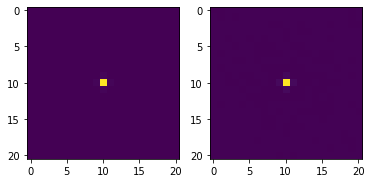

In [48]:
%matplotlib inline
_, axs = plt.subplots(1,2)
im1 = axs[0].imshow(s_train[35, :, :])
# plt.colorbar(im1)
im2 = axs[1].imshow(pred_all[35, :, :])
# plt.colorbar(im2)

np.linalg.norm(s_train[35, :, :].flatten() -\
            pred_all[35, :, :].flatten()) / np.linalg.norm(s_train[35, :, :].flatten())

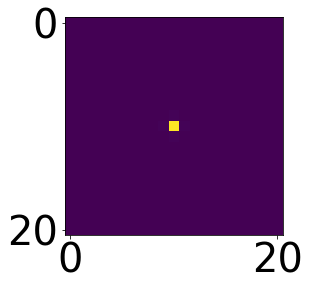

In [20]:
ground_truth_all.flatten() - pred_all.flatten()

(3087000,)

In [21]:
ground_truth_all.flatten().shape

(3087000,)

In [17]:
ground_truth_all.shape, pred_all.shape

((63000, 21, 21), (63000, 21, 21))

# Saving files

## First save it to a .pb file

In [34]:
# model.save(ckpt_fpath[:-8] + "saved_model")
model.save(ckpt_fpath[:-8] + "saved_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /work/HaiyangHe/ThermalArtist/DecaySurface/210um/DeepONet_v01/Checkpoint/saved_model/assets


## Then save it to a tflite file

In [37]:
ckpt_fpath[:-8]

'/work/HaiyangHe/ThermalArtist/DecaySurface/210um/DeepONet_v01/Checkpoint/'

In [39]:
import tensorflow as tf

# Convert the model.
# converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(ckpt_fpath)
converter = tf.lite.TFLiteConverter.from_saved_model(ckpt_fpath[:-8] + 'saved_model')
# converter = tf.lite.TFLiteConverter.from_saved_model(ckpt_fpath)
tflite_model = converter.convert()

# Save the model.
with open(ckpt_fpath[:-8] + 'DeepONet_model_full_data.tflite', 'wb') as f:
    f.write(tflite_model)

In [21]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
# interpreter = tf.lite.Interpreter(model_path=ckpt_fpath[:-8] + "model.tflite")
# interpreter = tf.lite.Interpreter(model_path=ckpt_fpath + "model.tflite")
interpreter = tf.lite.Interpreter(model_path=ckpt_fpath + "DeepONet_model_full_data.tflite")

interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

pred = np.empty((0, 1))
for i in range(u_train.shape[0]):
# for i in range(unit_size):
    u_tr = u_train[i:i+1, :]
    y_tr = y_train[i:i+1, :]
    # Test the model on random input data.
    input_shape_1 = input_details[0]['shape']
    input_data_1 = np.array(u_tr, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data_1)

    input_shape_2 = input_details[1]['shape']
    input_data_2 = np.array(y_tr, dtype=np.float32)
    interpreter.set_tensor(input_details[1]['index'], input_data_2)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = np.vstack((pred, output_data))
print(pred.shape)

(601000, 1)


In [24]:
pred.max()

1.0074985027313232

In [25]:
pred.min()

-0.001994352787733078

In [41]:
aaa = ((s_train- s_train.min()) / (s_train.max() - s_train.min()))

In [42]:
np.linalg.norm(aaa - pred)/np.linalg.norm(aaa)

2.2518351718211433

In [31]:
np.linalg.norm(pred - (s_train- s_train.min()) / (s_train.max() - s_train.min())) / np.linalg.norm((s_train- s_train.min()) / (s_train.max() - s_train.min()))

2.2518351718211433

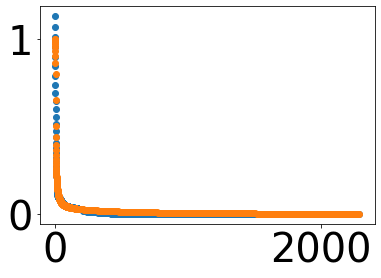

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_train[i*unit_size:(i+1) * unit_size, :].flatten(), pred.flatten())
ax.scatter(y_train[i*unit_size:(i+1) * unit_size, :].flatten(), s_train[i*unit_size:(i+1) * unit_size, :].flatten())

In [68]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=ckpt_fpath[:-8] + "model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape_1 = input_details[0]['shape']
input_data_1 = np.array(np.random.random_sample(input_shape_1), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data_1)

input_shape_2 = input_details[1]['shape']
input_data_2 = np.array(np.random.random_sample(input_shape_2), dtype=np.float32)
interpreter.set_tensor(input_details[1]['index'], input_data_2)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.19477734]]


In [6]:
%matplotlib inline
import tensorflow as tf
# tf.keras.backend.set_floatx('float64')
# tf.config.experimental_run_functions_eagerly(True)
import numpy as np
from tensorflow.keras import Model, losses
from tensorflow.keras.layers import Input, Dense, Reshape, Multiply
import time
import keras
from keras.optimizers import Adam
# import types
import tempfile
import keras.models
tf.keras.backend.set_floatx('float32')

activation = tf.keras.activations.swish
# define two sets of inputs
inputA = Input(shape=(7,))
inputB = Input(shape=(1,))
# the first branch operates on the first input
x = Dense(32, activation=activation)(inputA)
x = Dense(32, activation=activation)(x)
x = Dense(32, activation=activation)(x)
x = Dense(32, activation=activation)(x)
x = Dense(32, activation=activation)(x)
x = Dense(32, activation=activation)(x)
x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Dense(32, activation=activation)(inputB)
y = Dense(32, activation=activation)(y)
y = Dense(32, activation=activation)(y)
y = Dense(32, activation=activation)(y)
y = Dense(32, activation=activation)(y)
y = Dense(32, activation=activation)(y)
y = Model(inputs=inputB, outputs=y)


combined = Multiply()([x.output, y.output])
out = tf.math.reduce_sum(combined, axis = 1)
out = tf.keras.backend.reshape(out, (-1, 1))

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=out)

trainEpochVector = []
trainLossVector = []
testLossVector = []
def plotLossHistory(trainEpochVector, trainLossVector, testLossVector):        
    font_size = 12
    fig_loss, ax_loss = plt.subplots()
    plt.rcParams.update({'font.size': font_size})
    plt.subplots_adjust(left=0.25, bottom=0.15, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    ax_loss.plot(trainEpochVector, np.log10(trainLossVector), 'b-.')
    ax_loss.plot(trainEpochVector, np.log10(testLossVector), 'r-*')
    ax_loss.legend(['Train loss', 'Test loss'])
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel("Log loss")
    ax_loss.title.set_text('Total loss history')
    fig_loss_history = fig_fpath + "LossHistory.png"
    plt.savefig(fig_loss_history)
    plt.close()

def test_and_save(model, epoch):        
    font_size = 40
    fig = plt.figure(figsize=(40, 12), dpi = 100)
    plt.rcParams.update({'font.size': font_size})
    fig.suptitle('DeepONet on test set', y=0.99)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.85, wspace=0.25, hspace=0.1)
    num_subplot = 1
    idx = np.random.choice(u_test.shape[0] // unit_size)
    for i in range(num_subplot):            
        u_validate = u_test[idx * unit_size: (idx+1)*unit_size, :]
        y_validate = y_test[idx * unit_size: (idx+1)*unit_size, :]
        s_validate = s_test[idx * unit_size: (idx+1)*unit_size, :]

        s_pred = model.predict([u_validate, y_validate])
        axs = fig.add_subplot(131)
        im = axs.scatter(y_validate[:, 0], s_validate, cmap = 'jet', alpha = 0.9)
        axs.set_title("Ground Truth")
        plt.xlim(0, 0.02)
#             plt.colorbar(im)

        axs = fig.add_subplot(132)
        im = axs.scatter(y_validate[:, 0], s_pred, cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Prediction")
        plt.xlim(0, 0.02)
#             plt.colorbar(im)

        axs = fig.add_subplot(133)
        im = axs.scatter(y_validate[:, 0], np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Error")
        plt.xlim(0, 0.02)
#             plt.colorbar(im)

    path = f"./DeepONet_v0{trial}/fig/"
    fig_test_name = path + "Test_tf_pred_epoch_{0}.png".format(epoch)
    plt.savefig(fig_test_name)
    plt.close()
        
def validate_and_save(model, epoch):        
    font_size = 40
    fig = plt.figure(figsize=(40, 12), dpi = 100)
    plt.rcParams.update({'font.size': font_size})

    fig.suptitle('DeepONet on training set', y=0.99)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.85, wspace=0.25, hspace=0.1)

    num_subplot = 1
    idx = np.random.choice(u_train.shape[0] // unit_size)

    for i in range(num_subplot):   
        u_validate = u_train[idx * unit_size: (idx+1)*unit_size, :]
        y_validate = y_train[idx * unit_size: (idx+1)*unit_size, :]
        s_validate = s_train[idx * unit_size: (idx+1)*unit_size, :]

#         tf_dict = {self.X_func_tf: u_validate, self.X_loc_tf: y_validate} 
#         s_pred = self.sess.run(self.y_pred, tf_dict)
        s_pred = model.predict([u_validate, y_validate])

        axs = fig.add_subplot(131)
        im = axs.scatter(y_validate[:, 0], s_validate, cmap = 'jet', alpha = 0.9)
        axs.set_title("Ground Truth")
        plt.xlim(0, 0.02)
#             plt.colorbar(im)

        axs = fig.add_subplot(132)
        im = axs.scatter(y_validate[:, 0], s_pred, cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Prediction")
        plt.xlim(0, 0.02)
#             plt.colorbar(im)

        axs = fig.add_subplot(133)
        im = axs.scatter(y_validate[:, 0],np.abs(s_pred - s_validate), cmap = 'jet', alpha = 0.9)
        axs.set_title("DeepONet Error")
        plt.xlim(0, 0.02)

    path = f"./DeepONet_v0{trial}/fig/"
    fig_test_name = path + "Validation_tf_pred_epoch_{0}.png".format(epoch)
    plt.savefig(fig_test_name)
    plt.close()
    
with tf.device('/device:GPU:1'):
    model.compile(optimizer=Adam(learning_rate=5e-4), loss="mse")
    epoch = 2500000
    start_time = time.time()
    min_loss = 10**3
    for i in range(epoch):
        hist = model.fit([u_train, y_train], s_train, batch_size=u_train.shape[0],\
                         validation_data=([u_test, y_test], s_test), epochs=1, verbose=0)
        if i % 100 == 0:
            elapsed = time.time() - start_time
            loss = hist.history['loss'][0]
            val_loss = hist.history['val_loss'][0]
            if loss < min_loss:
                min_loss = loss
                ckpt_fpath = path + f"/DeepONet_v0{trial}/Checkpoint/model.h5"
                model.save(ckpt_fpath)
            print(f'Epoch: {i}, elapsed: {elapsed:.2e}, train loss: {loss:.5e}, val loss: {val_loss:.5e}, min loss: {min_loss:.5e}')
            start_time = time.time()
            trainLossVector.append(loss)  
            testLossVector.append(val_loss)
            trainEpochVector.append(i)
        if i % 5000 == 0:
            test_and_save(model, i)
            validate_and_save(model, i)
    plotLossHistory(trainEpochVector, trainLossVector, testLossVector)

Epoch: 0, elapsed: 1.36e+00, train loss: 2.87828e-02, val loss: 2.86491e-02, min loss: 2.87828e-02
Epoch: 100, elapsed: 1.17e+01, train loss: 1.78073e-02, val loss: 1.78074e-02, min loss: 1.78073e-02
Epoch: 200, elapsed: 1.01e+01, train loss: 1.68342e-02, val loss: 1.69228e-02, min loss: 1.68342e-02
Epoch: 300, elapsed: 9.62e+00, train loss: 1.59022e-02, val loss: 1.59875e-02, min loss: 1.59022e-02
Epoch: 400, elapsed: 9.73e+00, train loss: 1.41949e-02, val loss: 1.41820e-02, min loss: 1.41949e-02
Epoch: 500, elapsed: 9.61e+00, train loss: 8.85103e-03, val loss: 8.70470e-03, min loss: 8.85103e-03
Epoch: 600, elapsed: 9.76e+00, train loss: 5.74908e-03, val loss: 5.64450e-03, min loss: 5.74908e-03
Epoch: 700, elapsed: 9.82e+00, train loss: 3.83678e-03, val loss: 3.79904e-03, min loss: 3.83678e-03
Epoch: 800, elapsed: 9.63e+00, train loss: 2.69628e-03, val loss: 2.67551e-03, min loss: 2.69628e-03
Epoch: 900, elapsed: 9.70e+00, train loss: 1.90138e-03, val loss: 1.91621e-03, min loss: 1.90

In [24]:
print(model.inputs[0].dtype)

<dtype: 'float32'>


In [17]:
model.load_weights(ckpt_fpath)

In [1]:
import tensorflow as tf

# Convert the model.
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(ckpt_fpath)
tflite_model = converter.convert()

# Save the model.
with open(ckpt_fpath[:-8] + 'model.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'ckpt_fpath' is not defined

In [73]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=ckpt_fpath[:-8] + "model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape_1 = input_details[0]['shape']
input_data_1 = np.array(np.random.random_sample(input_shape_1), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data_1)

input_shape_2 = input_details[1]['shape']
input_data_2 = np.array(np.random.random_sample(input_shape_2), dtype=np.float32)
interpreter.set_tensor(input_details[1]['index'], input_data_2)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[-0.0333605]]


In [77]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=ckpt_fpath[:-8] + "model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

pred = np.empty((0, 1))
for i in range(u_train.shape[0]):
    u_tr = u_train[i:i+1, :]
    y_tr = y_train[i:i+1, :]
    # Test the model on random input data.
    input_shape_1 = input_details[0]['shape']
    input_data_1 = np.array(u_tr, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data_1)

    input_shape_2 = input_details[1]['shape']
    input_data_2 = np.array(y_tr, dtype=np.float32)
    interpreter.set_tensor(input_details[1]['index'], input_data_2)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = np.vstack((pred, output_data))
print(pred.shape)

(540900, 1)


In [42]:
u_train.shape

(540900, 7)